In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mudassarmanzoor","key":"4a98285908877a2ca2cc7014da768ad2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset -p /content


Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset
License(s): unknown
100% 3.51G/3.52G [00:39<00:00, 58.5MB/s]
100% 3.52G/3.52G [00:39<00:00, 95.7MB/s]


In [5]:
!unzip /content/pascal-voc-2012-dataset.zip -d /content/pascal_voc_2012

Streaming output truncated to the last 5000 lines.
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001874.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001876.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001882.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001885.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001895.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001896.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001926.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001966.png  
  inflating: /content/pascal_voc_2012/VOC2012_train_val/VOC2012_train

In [9]:
import os
import xml.etree.ElementTree as ET
import random
import shutil

# Paths for the original dataset
base_path = '/content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val'
annotations_path = os.path.join(base_path, 'Annotations')
images_path = os.path.join(base_path, 'JPEGImages')

# Path for saving the subset
subset_path = '/content/pascal_voc_subset'
os.makedirs(subset_path, exist_ok=True)

# Define classes and the target number of images per class
classes_to_include = ["person", "dog", "cat", "car", "bicycle", "bus", "motorbike", "aeroplane", "train", "bird"]
images_per_class = 5000

# Dictionary to store selected images for each class
selected_images = {class_name: [] for class_name in classes_to_include}

def get_image_classes(annotation_file):
    """
    Parse annotation XML to get all classes in an image.
    """
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    classes = set()

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in classes_to_include:
            classes.add(class_name)

    return list(classes)

# Step 1: Go through each annotation file and classify images by class
for annotation_file in os.listdir(annotations_path):
    # Full path to the annotation XML file
    annotation_path = os.path.join(annotations_path, annotation_file)
    image_name = os.path.splitext(annotation_file)[0]  # Get the image name without .xml extension

    # Get classes for the current image
    image_classes = get_image_classes(annotation_path)

    # Add image to lists for each relevant class
    for class_name in image_classes:
        if len(selected_images[class_name]) < images_per_class:
            selected_images[class_name].append(image_name)

    # Stop when we have enough images for all classes
    if all(len(selected_images[class_name]) >= images_per_class for class_name in classes_to_include):
        break

# Step 2: Copy selected images and annotations to the subset directory
for class_name, image_list in selected_images.items():
    print(f"Copying {len(image_list)} images for class '{class_name}'")

    for image_name in image_list:
        # Paths for the image and annotation file
        image_file = os.path.join(images_path, f"{image_name}.jpg")
        annotation_file = os.path.join(annotations_path, f"{image_name}.xml")

        if os.path.exists(image_file) and os.path.exists(annotation_file):
            # Copy to subset directory
            shutil.copy(image_file, subset_path)
            shutil.copy(annotation_file, subset_path)

print("Subset creation complete. Images and annotations are stored in:", subset_path)


Copying 5000 images for class 'person'
Copying 1341 images for class 'dog'
Copying 1128 images for class 'cat'
Copying 1284 images for class 'car'
Copying 603 images for class 'bicycle'
Copying 467 images for class 'bus'
Copying 575 images for class 'motorbike'
Copying 716 images for class 'aeroplane'
Copying 589 images for class 'train'
Copying 811 images for class 'bird'
Subset creation complete. Images and annotations are stored in: /content/pascal_voc_subset


In [10]:
!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repo
%cd yolov5
!pip install -r requirements.txt  # Install requirements


Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 46.8 MB/s eta 0:00:00


In [6]:
import os
import random
from PIL import Image
import shutil

# Define dataset root
original_dataset_path = 'pascal_voc_2012'
yolo_dataset_path = '/kaggle/working/yolo_dataset'

In [7]:
# to make directories like
#yolo_dataset
    #train
    #val
yolo_dirs = [
    os.path.join(yolo_dataset_path, 'images', 'train'),
    os.path.join(yolo_dataset_path, 'images', 'val'),
    os.path.join(yolo_dataset_path, 'labels', 'train'),
    os.path.join(yolo_dataset_path, 'labels', 'val')
]

In [8]:
for yolo_dir in yolo_dirs:
    os.makedirs(yolo_dir, exist_ok=True)

In [9]:
import os
pascal_voc_path = '/content/pascal_voc_2012'
folder_names = [f for f in os.listdir(pascal_voc_path) if os.path.isdir(os.path.join(pascal_voc_path, f))]
folder_names

['VOC2012_test', 'VOC2012_train_val']

In [10]:
import os
import random
from PIL import Image
import shutil

# Define dataset root
# original_dataset_path = 'pascal_voc_2012'  # This was the original incorrect path
# original_dataset_path = '/content/pascal_voc_2012' # This was the previous suggested path, but it's still incorrect
original_dataset_path = '/content/pascal_voc_2012/VOC2012_train_val/VOC2012_train_val'  # Updated path based on your latest comment

yolo_dataset_path = '/kaggle/working/yolo_dataset'

# Modified path based on file content to reflect the actual data location
jpeg_images_dir = os.path.join(original_dataset_path, 'JPEGImages')
annotations_dir = os.path.join(original_dataset_path, 'Annotations')

# Check if the updated paths exist
if not os.path.exists(jpeg_images_dir) or not os.path.exists(annotations_dir):
    raise FileNotFoundError(f"The directory {jpeg_images_dir} or {annotations_dir} does not exist. Please verify the dataset path.")

image_filenames = os.listdir(jpeg_images_dir)
image_ids = [os.path.splitext(filename)[0] for filename in image_filenames if filename.endswith('.jpg')]

In [11]:
random.seed(42)
random.shuffle(image_ids)
split_index = int(0.8 * len(image_ids)) #Spliting the dataset 80% for training, 20% for validation
train_ids = image_ids[:split_index] #taking the first 80% pictures
val_ids = image_ids[split_index:] #taking remaining 20% pictures

In [12]:
import xml.etree.ElementTree as ET
#this fucntion converts PASCAL_VOC annotations to YOLO format
def create_yolo_annotation(xml_file_path, yolo_label_path, label_dict):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = [] #list that will store the converted YOLO annotations.

    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in label_dict:
            continue
        label_idx = label_dict[label]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # this is YOLOv8 annotation format: label x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        annotations.append(f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    #annotations to the label file
    with open(yolo_label_path, 'w') as f:
        f.write("\n".join(annotations))

In [13]:
label_dict = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
    'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

In [14]:
for image_set, ids in [('train', train_ids), ('val', val_ids)]:
    for img_id in ids:
        img_src_path = os.path.join(jpeg_images_dir, f'{img_id}.jpg')
        label_dst_path = os.path.join(yolo_dataset_path, 'labels', image_set, f'{img_id}.txt')

        # Create the YOLO annotation file
        xml_file_path = os.path.join(annotations_dir, f'{img_id}.xml')
        if not os.path.exists(xml_file_path):
            print(f"Warning: Annotation {xml_file_path} not found, skipping.")
            continue
        create_yolo_annotation(xml_file_path, label_dst_path, label_dict)

        # Copy the image to the new YOLO dataset structure
        img_dst_path = os.path.join(yolo_dataset_path, 'images', image_set, f'{img_id}.jpg')
        shutil.copy(img_src_path, img_dst_path)

In [15]:
yaml_content = f"""
train: {os.path.join(yolo_dataset_path, 'images/train')}
val: {os.path.join(yolo_dataset_path, 'images/val')}

nc: {len(label_dict)}
names: {list(label_dict.keys())}
"""

with open(os.path.join(yolo_dataset_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

In [18]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n.pt')  # Use the YOLOv8 nano model

# Train the model
model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Path to dataset config file
    epochs=10,  # Number of epochs
    imgsz=640,  # Image size
    batch=16,  # Batch size
    name='yolov8_pascal_voc'  # Experiment name
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]


Ultralytics 8.3.26 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_pascal_voc, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/labels/train... 13700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13700/13700 [00:35<00:00, 385.31it/s]


train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val... 3425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3425/3425 [00:06<00:00, 562.74it/s]


val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/yolov8_pascal_voc/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_pascal_voc
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.42G      0.972      2.666      1.265          8        640: 100%|██████████| 857/857 [04:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:33<00:00,  3.26it/s]


                   all       3425       8012      0.573      0.553      0.561      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.38G      1.059      2.011      1.327          7        640: 100%|██████████| 857/857 [04:38<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:30<00:00,  3.49it/s]


                   all       3425       8012       0.59      0.516       0.53      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.42G      1.092      1.822      1.357          4        640: 100%|██████████| 857/857 [04:29<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:30<00:00,  3.58it/s]


                   all       3425       8012      0.571      0.477      0.497      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.35G      1.074       1.65      1.339         12        640: 100%|██████████| 857/857 [04:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:28<00:00,  3.80it/s]


                   all       3425       8012       0.62      0.501      0.544      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.41G      1.037      1.498      1.313          4        640: 100%|██████████| 857/857 [04:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:30<00:00,  3.60it/s]


                   all       3425       8012      0.656      0.535       0.58      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.4G     0.9981      1.384      1.285          5        640: 100%|██████████| 857/857 [04:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:30<00:00,  3.53it/s]


                   all       3425       8012      0.649      0.572      0.607      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.48G     0.9555      1.276      1.251          6        640: 100%|██████████| 857/857 [04:32<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:28<00:00,  3.75it/s]


                   all       3425       8012      0.654      0.593      0.629       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.47G     0.9216      1.194      1.224          6        640: 100%|██████████| 857/857 [04:35<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:29<00:00,  3.71it/s]


                   all       3425       8012      0.704      0.582      0.648      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.46G     0.8878      1.127        1.2         11        640: 100%|██████████| 857/857 [04:32<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:29<00:00,  3.65it/s]


                   all       3425       8012      0.702      0.607      0.664      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.46G     0.8627      1.063      1.178         10        640: 100%|██████████| 857/857 [04:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:30<00:00,  3.56it/s]


                   all       3425       8012      0.732      0.591      0.676      0.506

10 epochs completed in 0.850 hours.
Optimizer stripped from runs/detect/yolov8_pascal_voc/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_pascal_voc/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_pascal_voc/weights/best.pt...
Ultralytics 8.3.26 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:32<00:00,  3.32it/s]


                   all       3425       8012      0.732      0.589      0.676      0.506
             aeroplane        141        220      0.817      0.672      0.742      0.565
               bicycle        111        157      0.697      0.497      0.632      0.485
                  bird        160        216      0.766      0.634      0.717      0.512
                  boat        118        234      0.729      0.437      0.546      0.365
                bottle        151        293      0.692      0.406      0.472      0.311
                   bus         89        138      0.758      0.739      0.796      0.667
                   car        267        507      0.761      0.602      0.709      0.518
                   cat        213        232      0.839      0.806      0.871       0.72
                 chair        277        636      0.641      0.387      0.487       0.33
                   cow         68        164      0.729      0.591      0.716      0.486
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c604cb5a3e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [21]:
model_path = 'yolov8_pascal_voc.pt'
model.save(model_path)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3425 /kaggle/working/yolo_dataset/images/val/2007_000175.jpg: 448x640 2 sheeps, 221.4ms
image 2/3425 /kaggle/working/yolo_dataset/images/val/2007_000187.jpg: 480x640 2 tvmonitors, 186.5ms
image 3/3425 /kaggle/working/yolo_dataset/images/val/2007_000243.jpg: 448x640 1 aeroplane, 19.1ms
image 4/3425 /kaggle/working/yolo_dataset/images/val/2007_000333.jpg: 448x640 2 trains, 33.2ms
image 5/3425 /kaggle/working/yolo_dataset/images/val/2007_000364.jp

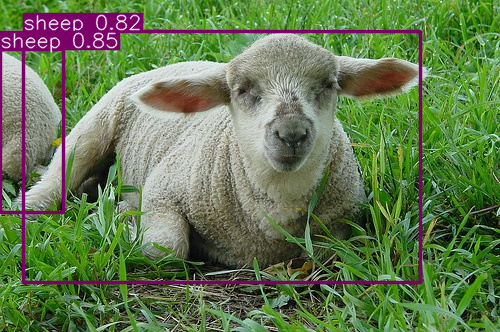

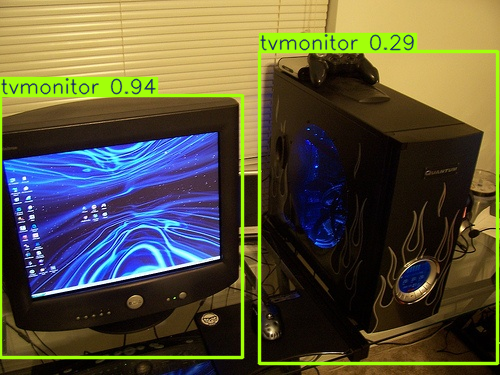

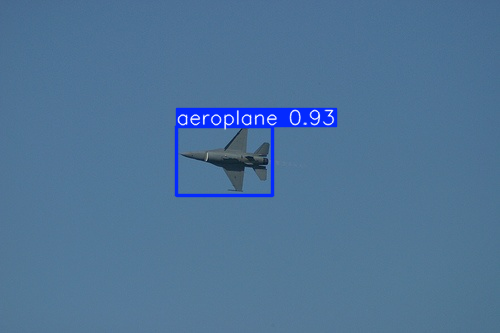

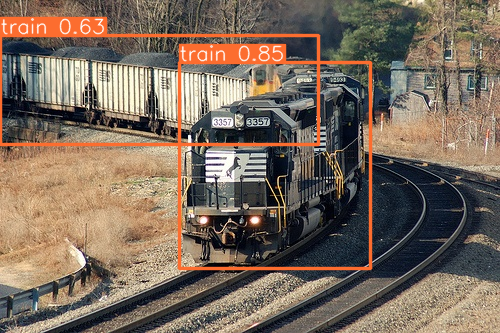

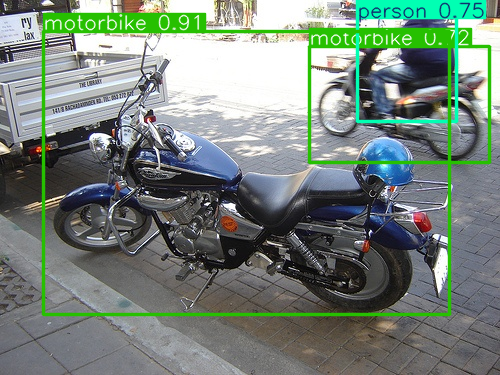

In [20]:
# Run inference on the validation set
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val'), save=True)

# Display only the first 5 predictions
for result in results[:5]:  # Slicing to get only the first 5 results
    result.show()
